In [18]:
import os
import numpy as np
import scipy
from scipy.io import wavfile
import scipy.fftpack as fft
from scipy.signal import get_window
import IPython.display as ipd
import matplotlib.pyplot as plt

%matplotlib inline

Sample rate: 16000Hz
Audio duration: 1.0s
Number of samples: 16000


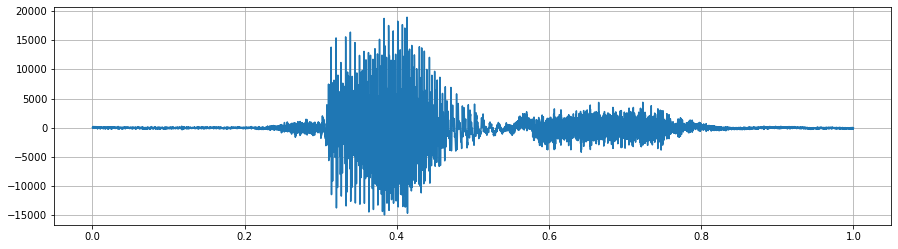

In [76]:
# AUDIO

# filename = "../f2bjrop1.0.wav"
filename = "../software/dataset/house//7192fddc_nohash_0.wav"
sample_rate, audio = wavfile.read(filename)
print("Sample rate: {0}Hz".format(sample_rate))
print("Audio duration: {0}s".format(len(audio) / sample_rate))
print("Number of samples:", len(audio))
plt.figure(figsize=(15,4))
plt.plot(np.linspace(0, len(audio) / sample_rate, num=len(audio)), audio)
plt.grid(True)

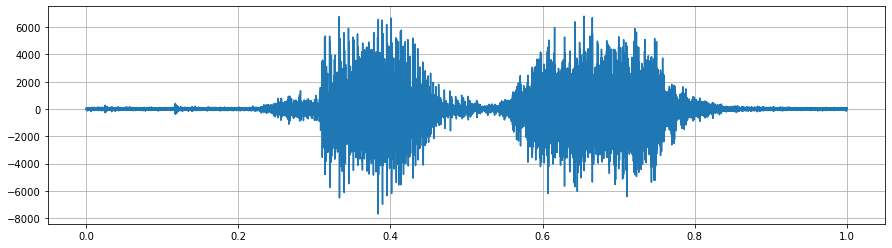

In [77]:
# PRE EMPHASIS

emphasis_coeff = 0.96875
audio_emphasis = np.append(audio[0], audio[1:] - emphasis_coeff * audio[:-1])
plt.figure(figsize=(15,4))
plt.plot(np.linspace(0, len(audio_emphasis) / sample_rate, num=len(audio_emphasis)), audio_emphasis)
plt.grid(True)

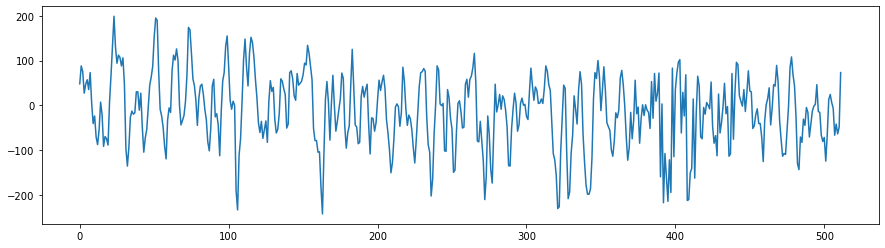

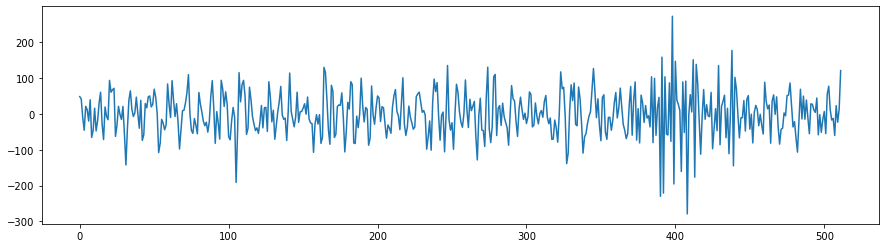

In [78]:
# FRAME

def frame_audio(audio, FFT_size=512, hop_len=170, sample_rate=16000):
    frame_num = int((len(audio) - FFT_size) / hop_len) + 1 # XXX last one with padding
    frames = np.zeros((frame_num, FFT_size))
    for n in range(frame_num):
        frames[n] = audio[n*hop_len:n*hop_len+FFT_size]
    return frames

FFT_size = 512
hop_len = FFT_size // 3
findex = 0
frames_audio = frame_audio(audio, FFT_size=FFT_size, hop_len=hop_len)
plt.figure(figsize=(15,4))
plt.plot(frames_audio[findex])

frames_emphasis = frame_audio(audio_emphasis, FFT_size=FFT_size, hop_len=hop_len)
plt.figure(figsize=(15,4))
plt.plot(frames_emphasis[findex])

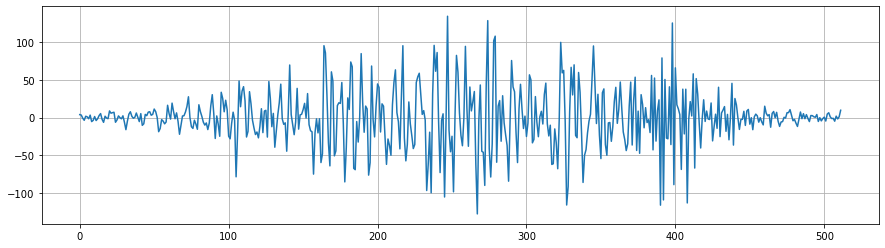

In [79]:
# WINDOW

window = get_window("hamm", FFT_size, fftbins=True)
audio_wins = frames_emphasis * window

plt.figure(figsize=(15,4))
plt.plot(audio_wins[findex])
plt.grid(True)

/usr/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


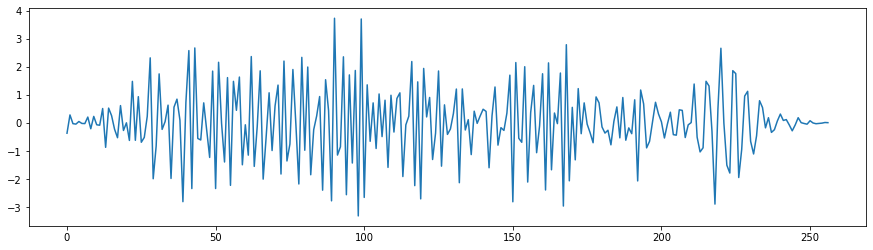

In [80]:
# FFT

audio_fft = []
size = int(1 + FFT_size // 2)
for i, frame in enumerate(audio_wins):
    audio_fft.append(fft.fft(frame, axis=0)[0:size] / 512)

plt.figure(figsize=(15,4))
plt.plot(audio_fft[findex])

# print(audio_fft)

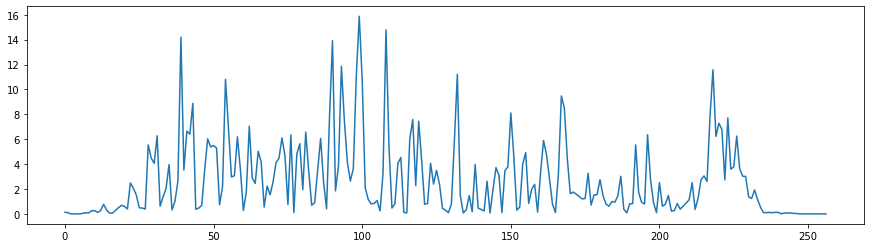

In [81]:
# POWER SPECTRUM

audio_power = np.square(np.abs(audio_fft))
plt.figure(figsize=(15,4))
plt.plot(audio_power[findex])

In [82]:
# FILTER BANK

freq_min = 0
freq_high = sample_rate / 2
mel_filter_num = 32

def freq_to_mel(freq):
    return 2595.0 * np.log10(1.0 + freq / 700.0)

def met_to_freq(mels):
    return 700.0 * (10.0**(mels / 2595.0) - 1.0)

def get_filter_points(fmin, fmax, mel_filter_num, FFT_size, sample_rate=44100):
    fmin_mel = freq_to_mel(fmin)
    fmax_mel = freq_to_mel(fmax)
    
    mels = np.linspace(fmin_mel, fmax_mel, num=mel_filter_num+2)
    freqs = met_to_freq(mels)
    
    return np.floor((FFT_size + 1) / sample_rate * freqs).astype(int)

def get_filters(filter_points, FFT_size):
    filters = np.zeros((len(filter_points)-2,int(FFT_size/2+1)))
    
    for n in range(len(filter_points)-2):
        filters[n, filter_points[n] : filter_points[n + 1]] = np.linspace(0, 1, filter_points[n + 1] - filter_points[n])
        filters[n, filter_points[n + 1] : filter_points[n + 2]] = np.linspace(1, 0, filter_points[n + 2] - filter_points[n + 1])
    
    return filters

[  0   1   3   5   8  10  13  15  18  22  25  29  33  38  42  48  53  59
  66  73  80  89  97 107 117 128 140 153 167 183 199 216 235 256]
[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [ 24  52  21 ...   8  11   9]
 [ 65 266  42 ...   8   7   7]
 [ 29 142  27 ...   1   2   2]]


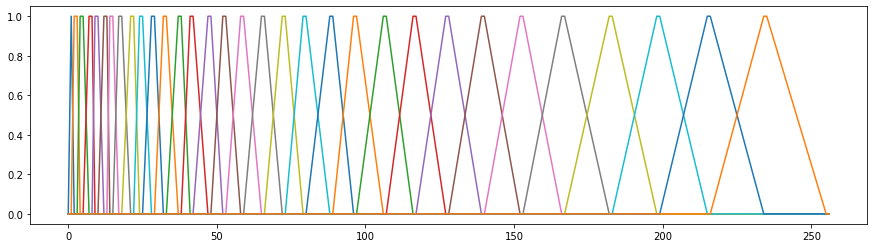

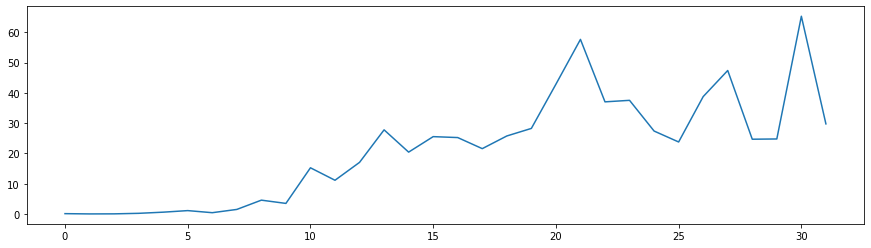

In [83]:
filter_points = get_filter_points(freq_min, freq_high, mel_filter_num, FFT_size, sample_rate=sample_rate)
print(filter_points)

filters = get_filters(filter_points, FFT_size)
plt.figure(figsize=(15,4))
for n in range(len(filters)):
    plt.plot(filters[n])

audio_filtered = np.dot(filters, np.transpose(audio_power))
print(audio_filtered.astype(int))
# print((audio_filtered / 2 / 65536))
plt.figure(figsize=(15,4))
plt.plot(np.transpose(audio_filtered)[findex])

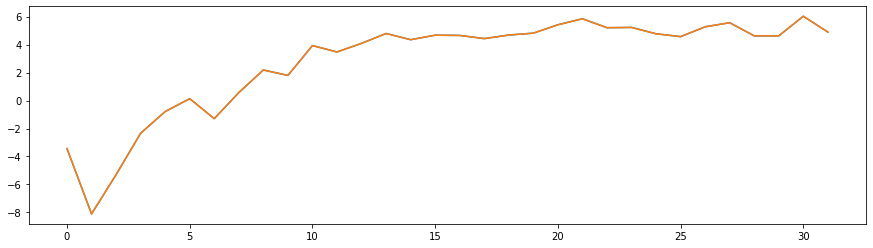

In [84]:
# LOG

# audio_log = [np.log2(audio_filtered / (2**i)) for i in range(1, 18)]
audio_log = np.log2(audio_filtered) #  / 2 / 65536)
# print(audio_log)

plt.figure(figsize=(15,4))
# for a in audio_log:
#     plt.plot(a)
plt.plot(np.transpose(audio_log)[findex])
#328048

prec = 8
audio_scale = (audio_log * (2**prec)).astype(int) / (2**prec)
# print(audio_scale)
plt.plot(np.transpose(audio_scale)[findex])

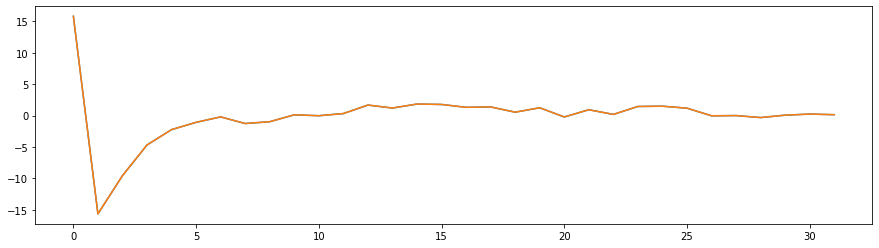

In [85]:
# DCT (implemented with 4 FFT)
# https://dsp.stackexchange.com/questions/2807/fast-cosine-transform-via-fft

dct_filter_num = mel_filter_num

audio_dct = scipy.fft.dct(np.transpose(audio_log), type=2, norm="ortho")
audio_dct_scale = scipy.fft.dct(np.transpose(audio_scale), type=2, norm="ortho")

plt.figure(figsize=(15,4))
# for a in audio_dct:
#     plt.plot(a)
plt.plot(audio_dct[findex])
plt.plot(audio_dct_scale[findex])

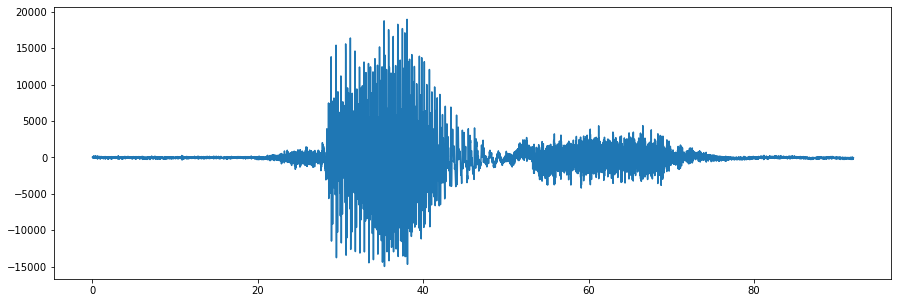

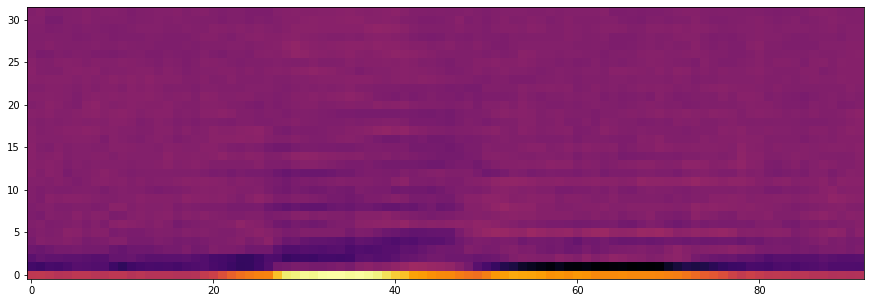

In [86]:
# IMAGE

plt.figure(figsize=(15,5))
plt.plot(np.linspace(0, audio_dct.shape[0], num=len(audio)), audio)

plt.figure(figsize=(15,5))
plt.imshow(np.transpose(audio_dct), aspect='auto', origin='lower', cmap="inferno");